##Załadowanie bibliotek 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import wget
import zipfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import os

In [4]:

if not os.path.isfile('ml-latest-small.zip'):
    wget.download('https://files.grouplens.org/datasets/movielens/ml-latest-small.zip')
    with zipfile.ZipFile("ml-latest-small.zip","r") as zip_ref:
        zip_ref.extractall()
elif not os.path.isdir('ml-latest-small'):
    with zipfile.ZipFile("ml-latest-small.zip","r") as zip_ref:
            zip_ref.extractall()
else:
    print('plik z danym już ściągnięty i rozpakowany')

plik z danym już ściągnięty i rozpakowany


In [5]:
#load film data from csv

movies_data = pd.read_csv('ml-latest-small/movies.csv')

#show first 5 movies

print(movies_data.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [6]:
#load user ratings from csv

ratings_data = pd.read_csv('ml-latest-small/ratings.csv')

#show first 5 ratings

print(ratings_data)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]


In [7]:
merged_data = pd.merge(ratings_data, movies_data, on='movieId')
print(merged_data.head())

   userId  movieId  rating   timestamp             title  \
0       1        1     4.0   964982703  Toy Story (1995)   
1       5        1     4.0   847434962  Toy Story (1995)   
2       7        1     4.5  1106635946  Toy Story (1995)   
3      15        1     2.5  1510577970  Toy Story (1995)   
4      17        1     4.5  1305696483  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy  


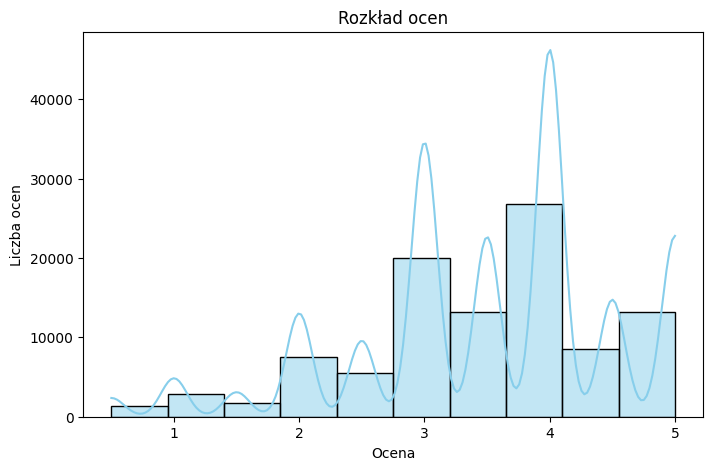

In [8]:
# Analiza rozkładu ocen
plt.figure(figsize=(8,5))
sns.histplot(merged_data['rating'], bins=10, kde=True, color='skyblue')
plt.title('Rozkład ocen')
plt.xlabel('Ocena')
plt.ylabel('Liczba ocen')
plt.show()

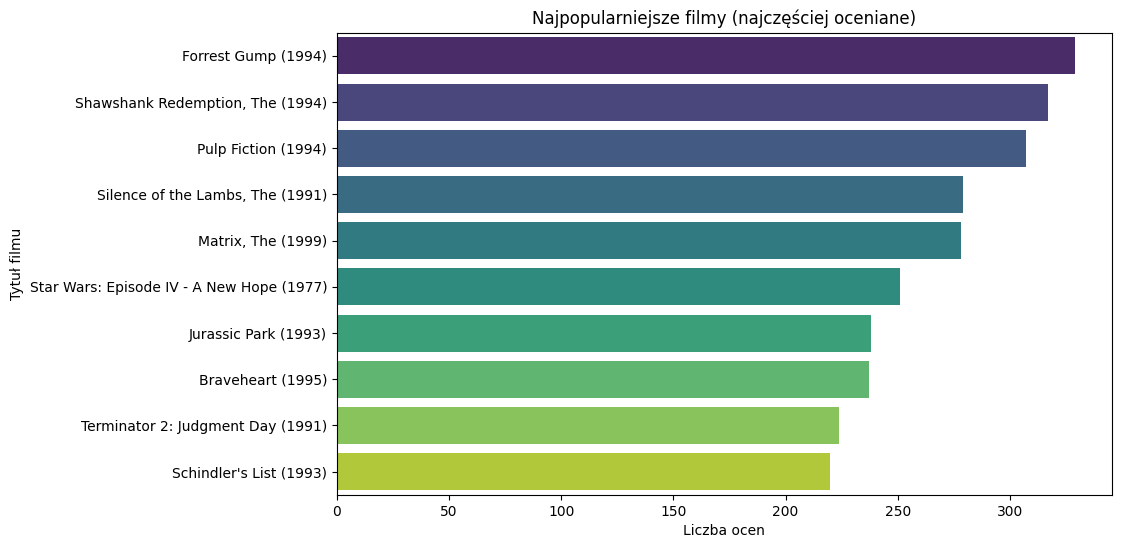

In [9]:
# Analiza popularności filmów (najczęściej ocenianych)
popular_movies = merged_data['title'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(y=popular_movies.index, x=popular_movies.values, palette='viridis')
plt.title('Najpopularniejsze filmy (najczęściej oceniane)')
plt.xlabel('Liczba ocen')
plt.ylabel('Tytuł filmu')
plt.show()

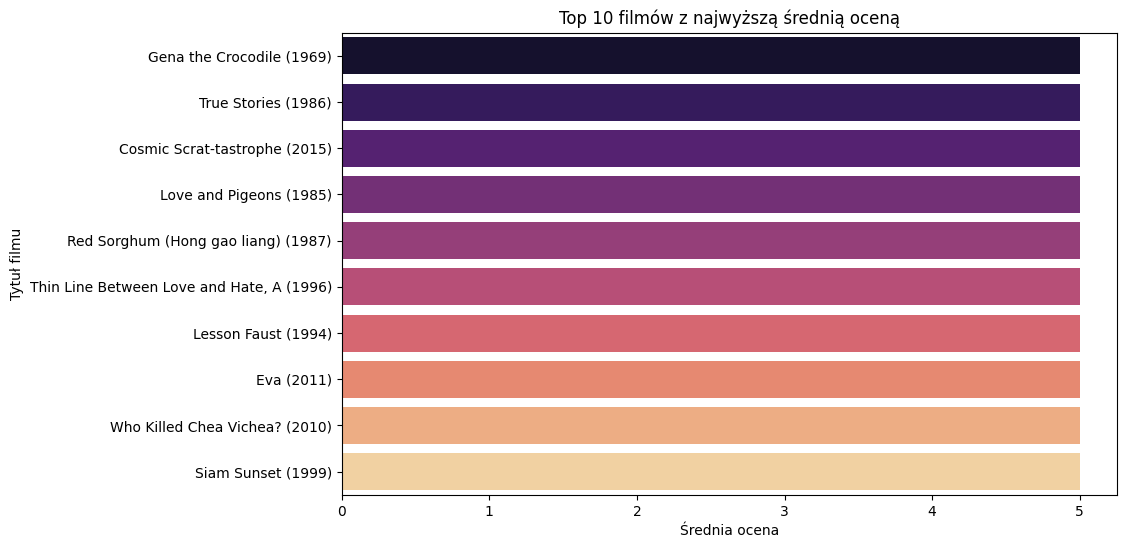

In [10]:

# Analiza średniej oceny dla poszczególnych filmów
average_ratings = merged_data.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(y=average_ratings.index, x=average_ratings.values, palette='magma')
plt.title('Top 10 filmów z najwyższą średnią oceną')
plt.xlabel('Średnia ocena')
plt.ylabel('Tytuł filmu')
plt.show()

In [11]:
def collaborative_filtering_user_based(user_id_to_find_recommendations_for, n_neighbors=10, top_recommendations=10):
    # Załaduj dane
    ratings_data = pd.read_csv('ml-latest-small/ratings.csv')

    # Krok 1: Przygotuj dane i stwórz macierz użytkowników i elementów
    user_item_matrix = ratings_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

    # Krok 2: Wybierz algorytm filtracji współpracującej (k-najbliższych sąsiadów)
    knn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute')
    knn_model.fit(user_item_matrix.values)

    # Krok 3: Znajdź rekomendacje filmów dla określonego użytkownika
    user_index = user_item_matrix.index.get_loc(user_id_to_find_recommendations_for)
    user_ratings = user_item_matrix.iloc[user_index].values

    # Krok 4: Znajdź najbliższych sąsiadów (podobnych użytkowników) dla docelowego użytkownika
    user_ratings_reshaped = user_ratings.reshape(1, -1)  # Przekształć do tablicy 2D z jednym wierszem
    _, indices = knn_model.kneighbors(user_ratings_reshaped)

    # Krok 5: Uzyskaj rekomendacje filmów na podstawie preferencji podobnych użytkowników
    similar_users_indices = indices.squeeze()
    recommendations = user_item_matrix.iloc[similar_users_indices].mean(axis=0)
    sorted_recommendations = recommendations.sort_values(ascending=False)

    # Wydrukuj najlepsze rekomendacje filmów
    recommended_movies = sorted_recommendations.head(top_recommendations)
    return recommended_movies


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

target_user_id = 42

top_recommendations = 10  
recommendations = collaborative_filtering_user_based(target_user_id, top_recommendations=top_recommendations)

ratings_data = pd.read_csv('ml-latest-small/ratings.csv')
movie_titles = pd.read_csv('ml-latest-small/movies.csv', index_col='movieId')['title']
user_item_matrix = ratings_data.pivot_table(index='userId', columns='movieId', values='rating')

user_item_matrix = user_item_matrix.dropna(axis=1, thresh=10)  # Keep movies with at least 10 non-NaN ratings


plt.figure(figsize=(10, 6))
for user, row in user_item_matrix.iterrows():
    plt.scatter([row.index], [user] * len(row), c=row.values, cmap='YlGnBu', s=100, vmin=1, vmax=5)

plt.colorbar(label='Rating')
plt.title('User-Item Matrix Scatter Plot')
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.show()


target_user_ratings = user_item_matrix.loc[target_user_id]
plt.figure(figsize=(8, 6))
plt.bar(target_user_ratings.index, target_user_ratings.values)
plt.title(f"Movie Ratings for User {target_user_id}")
plt.xlabel("Movie ID")
plt.ylabel("Rating")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=recommendations.values, y=[movie_titles[movie_id] for movie_id in recommendations.index])
plt.title(f"Top {top_recommendations} Movie Recommendations for User {target_user_id}")
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.show()

KeyboardInterrupt: 

In [15]:
def content_based_recommendation_system(movie_title_to_find_recommendations_for, top_recommendations=10):
    # Załóżmy, że dane 'movies.csv' zostały już załadowane
    movies_data = pd.read_csv('ml-latest-small/movies.csv')

    # Rozbij kolumnę "title" na osobne kolumny "title" i "year"
    movies_data[['title', 'year']] = movies_data['title'].str.extract(r'^(.*?)\s\((\d{4})\)$')

    # Wypełnij brakujące wartości w kolumnie "title" pustymi łańcuchami
    movies_data['title'] = movies_data['title'].fillna('')

    # Krok 1: Przygotuj dane i stwórz macierz TF-IDF dla tytułów i gatunków filmów
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
    tfidf_matrix_titles = tfidf_vectorizer.fit_transform(movies_data['title'])
    tfidf_matrix_genres = tfidf_vectorizer.fit_transform(movies_data['genres'].fillna(''))

    # Oblicz podobieństwo kosinusowe pomiędzy tytułami filmów
    cosine_similarities_titles = linear_kernel(tfidf_matrix_titles, tfidf_matrix_titles)

    # Oblicz podobieństwo kosinusowe pomiędzy gatunkami filmów
    cosine_similarities_genres = linear_kernel(tfidf_matrix_genres, tfidf_matrix_genres)

    # Znajdź indeks filmu, dla którego chcemy dokonać rekomendacji
    movie_index = movies_data.index[movies_data['title'] == movie_title_to_find_recommendations_for].tolist()[0]

    # Uzyskaj oceny podobieństwa (podobne tytuły filmów) dla danego filmu
    similar_titles_indices = cosine_similarities_titles[movie_index].argsort()[::-1][1:]
    similar_genres_indices = cosine_similarities_genres[movie_index].argsort()[::-1][1:]

    # Łącz podobne filmy na podstawie tytułów i gatunków
    combined_indices = list(set(similar_titles_indices[:top_recommendations]) | set(similar_genres_indices[:top_recommendations]))

    # Wyświetl rekomendacje filmów na podstawie treści (tytułów i gatunków)
    recommended_movies = movies_data.iloc[combined_indices][:top_recommendations]
    print(f"Top {top_recommendations} rekomendacji filmów dla filmu o tytule '{movie_title_to_find_recommendations_for}':")
    for idx, movie in recommended_movies.iterrows():
        print(f"Film: '{movie['title']}', Rok produkcji: {movie['year']}, Gatunek: {movie['genres']}")

# Przykładowe użycie:
movie_title = "Pulp Fiction"
content_based_recommendation_system(movie_title)


Top 10 rekomendacji filmów dla filmu o tytule 'Pulp Fiction':
Film: 'Fargo', Rok produkcji: 1996, Gatunek: Comedy|Crime|Drama|Thriller
Film: 'Confessions of a Dangerous Mind', Rok produkcji: 2002, Gatunek: Comedy|Crime|Drama|Thriller
Film: 'Andrew Dice Clay: Dice Rules', Rok produkcji: 1991, Gatunek: Comedy
Film: 'Beautiful Creatures', Rok produkcji: 2000, Gatunek: Comedy|Crime|Drama|Thriller
Film: 'In Bruges', Rok produkcji: 2008, Gatunek: Comedy|Crime|Drama|Thriller
Film: 'Man Bites Dog (C'est arrivé près de chez vous)', Rok produkcji: 1992, Gatunek: Comedy|Crime|Drama|Thriller
Film: 'Freeway', Rok produkcji: 1996, Gatunek: Comedy|Crime|Drama|Thriller
Film: 'Informant!, The', Rok produkcji: 2009, Gatunek: Comedy|Crime|Drama|Thriller
Film: 'Goodbye Lover', Rok produkcji: 1999, Gatunek: Comedy|Crime|Thriller
Film: 'Lumumba', Rok produkcji: 2000, Gatunek: Drama
